In [ ]:
!pip install sccoda pertpy

In [ ]:
!pip install toytree arviz ete3

In [1]:
import warnings

import pandas as pd

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

import scanpy as sc
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
import pertpy as pt

import itertools
import sys 

import gseapy as gp
from scipy.stats      import median_abs_deviation
import math

2024-09-26 01:08:44.620098: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


**Dataset Background**
1. 18 Ulcerative Collitis Patients
2. 12 Healthy Indivudals

"To investigate the transitions between healthy and chronically inflamed mucosa, while mitigating patient-specific variability, we collected paired samples from each subject in a single procedure. For UC patients, these were endoscopically assessed as adjacent normal tissue (“non-inflamed”) and inflamed or ulcerated tissue (“inflamed”) (Figure 1A, STAR Methods). To estimate intra-subject variation, we obtained two location-matched samples (distance of ~1–2 cm) from each of the 12 healthy subjects, as well as from both non-inflamed and inflamed regions of 3 UC patients. We then separated the “epithelial” (EPI) and “lamina propria” (LP) fractions from each sample, and performed scRNA-Seq (STAR Methods). We confirmed that expression of an inflammation-associated gene set increased from healthy to non-inflamed to inflamed samples (Figure 1B)."
**Image Here: https://www.google.com/search?client%253Dsafari%2526sca_esv%253D253929064fe52cf4%2526sca_upv%253D1%2526rls%253Den%2526sxsrf%253DADLYWIK1-PZ8_Fbn8luiWtNNOykG9xNruQ%253A1727228426780%2526q%253Depithelium%252Band%252Blamina%252Bpropria%2526udm%253D2%2526fbs%253DAEQNm0Aa4sjWe7Rqy32pFwRj0UkWd8nbOJfsBGGB5IQQO6L3J_86uWOeqwdnV0yaSF-x2jpXXSZVlK6C0YPjHbsLu8HQlFjXJu4aVhI_llTnXJ4lFAWdNYSKl18X_OYOML0jevhpDEumYRwaaY1jEa7vKdTgiN-XUHVrwULe1SBpdZ2b2Qdf9JCr6vszwGWtXx6BBaAiRVuZU26XGXcLhLP1MT26u-HDMw%2526sa%253DX%2526ved%253D2ahUKEwj7z8um-9yIAxUFLFkFHSrnMDIQtKgLegQIDxAB%2526biw%253D1152%2526bih%253D749%2526dpr%253D2#vhid%253DzR5UG27xz6A5VM%2526vssid%253Dmosaic"**

In [2]:
data = pt.data.smillie_2019()

**Most of the data was taken from two Epithelial Locations and two Lamina Propria Locations**
1. Subject N52, N58, and N111 do not have 4 samples for scRNAseq

In [3]:
unique_subjects       = list(data.obs['Subject'].unique())
sample_location_meta  = {}
for subject in unique_subjects:
    sample_location_meta[subject] = len(data.obs[(data.obs['Subject'] == subject)]['Sample'].unique())

sample_location_meta = pd.Series(sample_location_meta)

**Author ran patient samples separately**

"We observed substantial variability between cells that had been obtained from different human subjects, which likely reflects a combination of technical and biological differences. In some cases, these “batch effects” led to cells clustering first by patient or disease phenotype, rather than by cell type or cell state. To eliminate these batch differences, we ran ComBat (Johnson et al., 2007) with default parameters on the log2(TP10K+1) expression matrix, allowing cells to be clustered by cell type or cell state. Importantly, these batch-corrected data were only used for the PCA and all steps relying on PCA (e.g. clustering, diffusion map, t-SNE visualization); all other analyses (e.g. differential expression analysis) were based on the original expression data."

**Pull Study Design from Original Paper**

In [4]:
study_file_path    = 'smillie_study_design.xlsx'
sheet_names        = pd.ExcelFile(study_file_path).sheet_names
study_design       = pd.read_excel(study_file_path, sheet_name = sheet_names[0])

In [5]:
unique_metadata   = {}
for col in data.obs:
    unique_metadata[col] = data.obs[col].unique()

**Perform Quality Control**

In [6]:
def annotate_mitochondrial(gene_names, gene_library):
    ''' 
    Parameters:
        gene_names:
        gene_library:

    Returns:
        gene_names:
        
    '''
    annotated_genes = []
    for pathway in gene_library:
        if 'mitoch' in pathway.lower():
            genes = gene_library[pathway]

            for gene in gene_names:
                # Annotate Mitochondrial Genes
                if gene in genes:
                    annotated_genes.append('MT_' + gene)


    annotated_genes = pd.Series(annotated_genes).unique()
    return annotated_genes

mito_prefix         =   'MT_'
gene_names          =   list(data.var_names)
gene_library        =   gp.read_gmt('GO_Cellular_Component_2023.gmt')
mitochondrial_genes =   annotate_mitochondrial(gene_names, gene_library)

gene_names          =   [gene if mito_prefix + gene not in mitochondrial_genes else mito_prefix + gene for gene in gene_names]

# Rename genes to include mitochondrial prefixes
data.var_names      =   gene_names

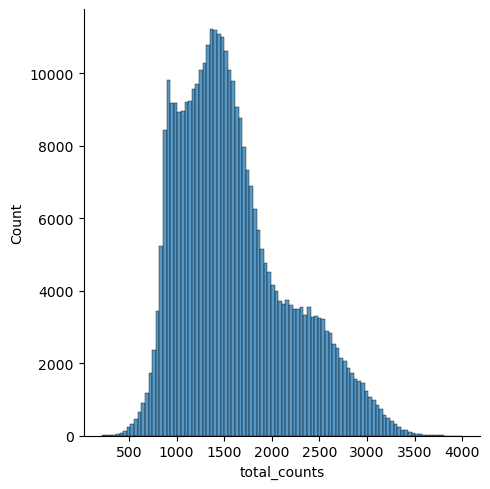

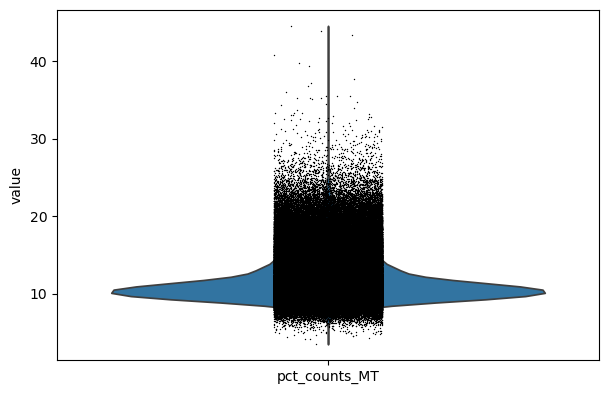

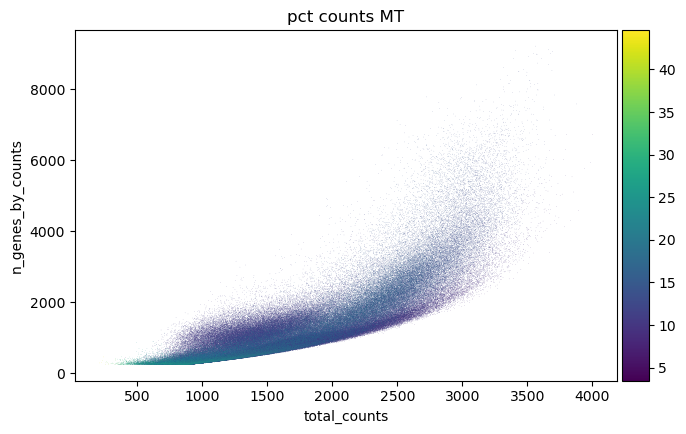

In [7]:
class ScanpyObject:

  # Data: Gene x Cell Row Matrix with Cells in index
  #       Columns Gene IDS correspond to the Columns

  # Leiden Groups: # of Groups for Clustering In Leiden Algorithm
  # Random State: The random seed introduced to Python for reproducability
  # PCA, UMAP, and TSNE utilitze a stochastic gradient algorithm (starting point matters)
  # PCA is determinsitic but due to the high rank of these datasets, "random PCA" may be used
  '''
  min_counts: The minimum counts needed for a cell to not be filtered out (low quality cells have low counts)
  '''
  # Metalables: Title of Column Describing Gene Categorization
  #             For example: mRNA, Protein coding, siRNA, etc.,

  def __init__(self,
               data,
               min_counts = None,
               leiden_groups = 15,
               random_state  = 42,
               percent_top   = 20, 
               mitochondrial_outlier = 8,
               metalabels    = 'protein_coding',
               log_data      = True,
               normalize     = True,
               plot_qc       = True,
               manual_filtering = False,
               target_sum    = 10000):

    self.log_data           = log_data

    if not isinstance(data, sc.AnnData):
        self.data_object    = sc.AnnData(data.copy())

    else:
        self.data_object    = data.copy()

    self.data_highvar       = None
    self.leiden_gene_groups = leiden_groups   # TSNE Plots leiden groups
    self.random_state       = random_state    # Seed For Reproducability

    if normalize:
      sc.pp.normalize_total(self.data_object, target_sum = target_sum)

    if log_data:
      sc.pp.log1p(self.data_object)

    self._preprocess_workflow(metalabels, min_counts, percent_top, manual_filtering, plot_qc, mitochondrial_outlier)
    
    self._regress_highvar()
#     sc.pp.highly_variable_genes(self.data_object, min_mean=0.0125, max_mean=3, min_disp=0.5)

    # self._regress_highvar()
    # self._nearest_neighbors()
    # self._dimension_reduction()
    
  
  # Find outliers with nMads = 6 by default
  def is_outlier(self, adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier


  def _preprocess_workflow(self, metalabels, min_counts, percent_top, manual_filtering, plot_qc, mitochondrial_outlier):
    
    # Initialize Variables Avoid Errors
    total_counts   = None
    n_genes_counts = None
    
    # Label 'MT_' genes as mitochondrial in AnnData
    self._mitochondrial()

    self._calculate_qc_metrics(percent_top)
    if plot_qc:
        self.plot_qc()
        
    if manual_filtering and min_counts is not None:
        self._filter_cells(min_counts)
    
    else:
  
        total_counts   = 'total_counts'
        n_genes_counts = 'n_genes_by_counts'

        # Use multiple criteria to find outliers likely indicating poor single cell quality
        self.data_object.obs['outlier'] = (
        self.is_outlier(self.data_object, total_counts, 5)  # 
        | self.is_outlier(self.data_object, n_genes_counts, 5)
        | self.is_outlier(self.data_object, f'pct_counts_in_top_{percent_top}_genes', 5)
        )
        
        self.data_object.obs["MT_outlier"] = self.is_outlier(self.data_object, "pct_counts_MT", 3) | (
        self.data_object.obs["pct_counts_MT"] > mitochondrial_outlier # 
        )

        
  def plot_qc(self):
    
    p1 = sns.displot(self.data_object.obs['total_counts'], bins=100, kde=False)
    # sc.pl.violin(adata, 'total_counts')
    p2 = sc.pl.violin(self.data_object, f'pct_counts_MT')
    p3 = sc.pl.scatter(self.data_object, 'total_counts', 'n_genes_by_counts', color='pct_counts_MT')
    
  def _mitochondrial(self, prefix = 'MT'):
    self.data_object.var[prefix] = self.data_object.var_names.str.startswith(prefix)
    
  def _filter_cells(self, min_counts):
    sc.pp.filter_cells(self.data_object, min_counts = min_counts)

  def _calculate_qc_metrics(self, percent_top):

    self.non_qc = ['highly_variable', 'means', 'dispersions', 'dispersions_norm']
    self.qc     = [col for col in self.data_object.var if col not in self.non_qc]
    
    sc.pp.calculate_qc_metrics(self.data_object, qc_vars=self.data_object.var[self.qc],
                                           percent_top=[percent_top], log1p=False, inplace=True)

  # Creates Another Object, With High Variability Genes Only
  def _regress_highvar(self):
    sc.pp.highly_variable_genes(self.data_object)
    self.data_highvar  = self.data_object[:, self.data_object.var.highly_variable]

  # Leiden Clustering
  def _nearest_neighbors(self):
    sc.pp.neighbors(self.data_highvar, n_neighbors=10, n_pcs=40)
    sc.tl.leiden(self.data_highvar) # calculate the neighbors

  def _retreive_ranked_groups(self):
    gene_groups     = self.leiden_gene_groups
    gene_ranks_list = list(self.data_highvar.uns['rank_genes_groups']['names'])
    if len(gene_ranks_list) != 0:
      ranked_groups = gene_ranks_list[:gene_groups]

    return ranked_groups

  def _dimension_reduction(self):
    sc.pp.pca(self.data_highvar, svd_solver = 'arpack', random_state = self.random_state)
    sc.tl.pca(self.data_highvar, svd_solver = 'arpack')
    sc.tl.rank_genes_groups(self.data_highvar, 'leiden', method='t-test')


  # def _attach_metalabels(self, metalabels):
    # for metalabel in ids[metalabels].unique():
    #   self.data_object.var[metalabel] = self.data_object.var_names.str.startswith(metalabel)

  def leiden_ranking(self):
    sc.pl.rank_genes_groups(self.data_highvar, n_genes=self.leiden_gene_groups, sharey=False)

  def marker_genes(self):
    markers       = 2
    ranked_groups = self._retreive_ranked_groups()
    top_ranked    = {value: list(ranked_groups[value])[0:markers] for value in range(len(ranked_groups))}

    return top_ranked

  # -------------------------------------------------------------------------------------
  # Plot UMAP Takes The Highest Rank Marker Gene and Plots with UMAP
  # UMAP (Unifold Manifold) is a technique that aims to separate similar groups
  # UMAP is purely a visual technqiue, meaning the axes have no meaning
  # Separation does indicate that the groups are similar, but not as interpretable as PCA

  def plot_umap(self, color_type = 'highly_variable'):
    highly_variable = self.marker_genes()
    highly_variable = list(highly_variable.values())
    highly_variable = [gene[0] for gene in highly_variable]

    # # highly_variable = ['ENSG00000001561', 'ENSG00000286231']
    sc.tl.paga(self.data_highvar)
    sc.pl.paga(self.data_highvar, plot     =  False)  # remove `plot=False` if you want to see the coarse-grained graph
    sc.tl.umap(self.data_highvar, init_pos = 'paga')

    if color_type == 'highly_variable':
      sc.pl.umap(self.data_highvar, color=highly_variable)
    else:
      sc.pl.umap(self.data_highvar, color = color_type)

  def pca(self, gene_id = 'ENSG00000283761'):
    sc.pl.pca(self.data_highvar, color = gene_id, annotate_var_explained = True)

  def plot_high_expr(self):
    sc.pl.highest_expr_genes(self.data_object, n_top = 20)

  def plot_tsne(self):
    sc.tl.tsne(self.data_highvar, use_rep = 'X_pca')
    sc.pl.tsne(self.data_highvar, color=["leiden"], cmap="tab20")

  
  def scatter_plots(self):
    if not self.data_object.var.empty:
      total_plots = len(self.data_object.var.columns)
      fig, ax     = plt.subplots(8,5, figsize=(40,24))
      row         = 0
      col         = 0
      for plot in range(total_plots):
          protein_type = str(self.data_object.var.columns[plot])
          try:
            sc.pl.scatter(self.data_object, x='total_counts',
                          y = 'pct_counts_' + protein_type, ax = ax[row, col], show = False)
          # Deal with ax[row, col] calling for

          # Total Counts, n_genes_counts, etc
          except ValueError:
            col -= 1     # Counter Col += 1 Count


          col += 1
          if col > 4:
              row += 1
              col = 0
    else:
      raise ValueError(f'''{self.data_object.var} does not contain any data. Preprocess
      metalabels to receive scatter plots''')

  def plot_highly_variable(self):
    sc.pl.highly_variable_genes(self.data_object)

  def plot_pca_variance_ratio(self):
    sc.pl.pca_variance_ratio(self.data_highvar, log=True)


# Mitochondrial Genes Look Good
# Total count depth looks good for all genes
# Filtering with is_outlier function keeps all data
# Data may have been filtered already

LOG_DATA    = True
NORMALIZE   = True
scanpy_obj1 = ScanpyObject(data,
                           min_counts       = None, 
                           log_data         = LOG_DATA, 
                           normalize        = NORMALIZE, 
                           percent_top      = 20,
                           mitochondrial_outlier = 20, 
                           manual_filtering = False)     # meta indexes data

adata       = scanpy_obj1.data_object

**Questions from Visualizing Data**
1. Does the high mitochondrial expression seem consistent with the biology of ulcerative collitis?
2. Do healthy cells have lower mitochondrial expression? 

In [8]:
import anndata2ri
import logging

import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

# Only Errors from R will be Displayed
rcb.logger.setLevel(logging.ERROR)

# Allows for Dataframe Conversion from R and Pandas seamlessly
ro.pandas2ri.activate()

# Allows for Anndata conversion to R seamlesleslly
anndata2ri.activate()

# Magic command to load the R jupyter notebooks extension with python
# %load_ext rpy2.ipython
%reload_ext rpy2.ipython

**Next Step 24Sep2024**
1. RUn each patient separately on scDblFinder and SoupX iteratively using zellkonverter
2. Download zellkonverter correctly

In [9]:
%%R
library(SingleCellExperiment)
library(Seurat)
library(scater)
library(scDblFinder)
library(BiocParallel)
library(SoupX)
library(S4Vectors)
library(zellkonverter)


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

Loading required package: SummarizedExperiment
Loading required package: MatrixGenerics
Loading required package: matrixStats

Attaching package: ‘MatrixGenerics’

The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats, rowProds, rowQuantiles, rowRanges, ro

**Doublet Detection using scDblFinder**

In [10]:
data_matrix = adata.X.T.toarray()

In [10]:
%%R

head(obs[, Subject], 6)

Error in h(simpleError(msg, call)) : 
  error in evaluating the argument 'x' in selecting a method for function 'head': object 'obs' not found


RInterpreterError: Failed to parse and evaluate line '\nhead(obs[, Subject], 6)\n'.
R error message: "Error in h(simpleError(msg, call)) : \n  error in evaluating the argument 'x' in selecting a method for function 'head': object 'obs' not found"

**Convering AnnData into R**
1. Only rerun if doublet design needs to change (09/25/2024), but it shoudlnt'

In [39]:
# %%R -o doublet_scores -o doublet_class

# library(reticulate)


# # Import the scanpy module from Python
# sc    <- import("scanpy")
# # Load the AnnData object
# adata <- sc$read_h5ad("smillie_2019_qc.h5ad")

# # Access the 'obs' (metadata) DataFrame from the AnnData object and convert it to R
# obs <- py_to_r(adata$obs)

# # Extract unique batches from the 'Subject' column in obs (assuming 'Subject' is your batch info)
# batches <- unique(obs$Subject)

# # Initialize lists for doublet scores and class
# doublet_scores <- list()
# doublet_class <- list()

# # Loop over each batch
# for (batch in batches) {
#   print(batch)
  
#   # Subset the 'obs' DataFrame to get the cells belonging to this batch
#   batch_cells <- obs$Subject == batch
  
#   # Get the indices of the cells belonging to the current batch
#   cell_indices <- which(batch_cells)
  
#   # Subset the expression matrix in the AnnData object (assume 'X' stores the counts)
#   subject_batch <- adata$X[cell_indices, ]  # Subset the counts matrix for the current batch
  
#   # Convert the expression matrix to R format (from sparse/dense matrix to regular R matrix)
#   subject_batch <- py_to_r(subject_batch)
#   subject_batch <- t(subject_batch)

#   # Check if the matrix is in dgRMatrix format
#   if (class(subject_batch) == "dgRMatrix") {
#     # Convert dgRMatrix to dense matrix first
#     subject_batch <- as.matrix(subject_batch)
    
#     # Convert dense matrix to dgCMatrix (column-compressed)
#     subject_batch <- as(subject_batch, "dgCMatrix")
#   }


#   # Get the gene names (rownames) and set them for the matrix
#   # Extract gene names from adata$var_names (a Pandas Index)
#   gene_names <- adata$var_names$tolist()  # Convert Pandas Index to list

#   # Convert the list to an R character vector
#   gene_names <- as.character(py_to_r(gene_names))

#   if (nrow(subject_batch) == length(gene_names)) {
#     rownames(subject_batch) <- gene_names
#   } else {
#     stop("The number of gene names does not match the number of rows in the expression matrix.")
#   }
    
#   # Subset the metadata for this batch
#   cell_metadata <- obs[batch_cells, ]
#   cell_metadata <- DataFrame(cell_metadata)
  
#   # Create the SingleCellExperiment object
#   sce_batch <- SingleCellExperiment(assays = list(counts = subject_batch),
#                                     colData = cell_metadata)
  
#   # Run scDblFinder on the subsetted SingleCellExperiment object
#   sce_batch <- scDblFinder(sce_batch)
  
#   # Store the doublet scores and classifications for the current batch
#   doublet_scores[[batch]] <- sce_batch$scDblFinder.score
#   doublet_class[[batch]]  <- sce_batch$scDblFinder.class
# }


[1] "N7"
[1] "N9"
[1] "N10"
[1] "N8"
[1] "N11"
[1] "N12"
[1] "N13"
[1] "N14"
[1] "N15"
[1] "N16"
[1] "N17"
[1] "N18"
[1] "N19"
[1] "N20"
[1] "N21"
[1] "N23"
[1] "N24"
[1] "N26"
[1] "N51"
[1] "N52"
[1] "N58"
[1] "N111"
[1] "N661"
[1] "N44"
[1] "N46"
[1] "N49"
[1] "N50"
[1] "N106"
[1] "N539"
[1] "N110"


Creating ~5000 artificial doublets...
Dimensional reduction
Evaluating kNN...
Training model...
iter=0, 164 cells excluded from training.
iter=1, 150 cells excluded from training.
iter=2, 141 cells excluded from training.
Threshold found:0.191
115 (2.6%) doublets called
Creating ~7104 artificial doublets...
Dimensional reduction
Evaluating kNN...
Training model...
iter=0, 721 cells excluded from training.
iter=1, 878 cells excluded from training.
iter=2, 871 cells excluded from training.
Threshold found:0.054
795 (6.7%) doublets called
Creating ~9986 artificial doublets...
Dimensional reduction
Evaluating kNN...
Training model...
iter=0, 1373 cells excluded from training.
iter=1, 1671 cells excluded from training.
iter=2, 1661 cells excluded from training.
Threshold found:0.014
1541 (9.3%) doublets called
Creating ~5000 artificial doublets...
Dimensional reduction
Evaluating kNN...
Training model...
iter=0, 53 cells excluded from training.
iter=1, 42 cells excluded from training.
iter=

**Since Samples were run separately for each Patient, It is valid to run scDblFinder for Each Patient**
1. Running separately will reduce the computational overhead
2. Running separately might be more valid.

**Read the processed doublets from R function since it takes ~ 40 mintues in function above**

In [50]:
def load_anndata(file = 'smillie_2019_processed_doublets.h5ad'):
    
    return  sc.read_h5ad(file)

load_anndata()


AnnData object with n_obs × n_vars = 365492 × 18172
    obs: 'Origin', 'Subject', 'Sample', 'Location', 'Replicate', 'Health', 'Cluster', 'nGene', 'nUMI', 'Major_l1', 'Major_l2', 'Major_l3', 'Major_l4', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_20_genes', 'total_counts_MT', 'pct_counts_MT', 'outlier', 'MT_outlier', 'doublet_score', 'doublet_class'
    var: 'MT', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p'

**Ambient RNA Detection**
1. Clustering algorithms help the ambient RNA detection algorithm

In [ ]:
# sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.leiden(adata, key_added = 'soupx_input')

soupx_input = adata.obs['soupx_input']

**First Task**
1. Does the metadata provide separate clusters for our metadata?
2. HC = Healthy Controls, UC  = Ulcerative Colitis, Colitis = Colities

In [ ]:
meta_data       = study_design[['Disease', 'Smoking']]
meta_data.index = study_design['Subject ID']

diseased_ids    = meta_data[(meta_data['Disease'] == 'Colitis') | (meta_data['Disease'] == 'UC')].index
healthy_ids     = meta_data[~meta_data.index.isin(diseased_ids)].index

diseased_ids, healthy_ids = list(diseased_ids), list(healthy_ids)

**Pull the Unique Molecular Identifiers (UMIs) for the Diseased and Healthy Samples**

In [ ]:
diseased_umis = data.obs[data.obs['Subject'].isin(diseased_ids)].index
healthy_umis  = data.obs[data.obs['Subject'].isin(healthy_ids)].index

**Data.X attribute appears to have the raw counts**
1. COnfirm this 09/20/2024

In [ ]:
plot = False
if plot:
    sns.displot(data.X[:, :30].toarray())

In [ ]:
data.layers['raw_counts'] = data.X.copy()

In [ ]:
total_reads = 10000
sc.pp.normalize_total(data, total_reads)
sc.pp.log1p(data)

In [ ]:
sc.pp.highly_variable_genes(data, max_mean = 3)

In [ ]:
data_highvar = data[:, data.var.highly_variable]

In [ ]:
data_highvar

In [ ]:
# sc.pp.pca(data_highvar)

In [ ]:
# sc.pp.neighbors(data_highvar)
# sc.tl.umap(data_highvar)

In [ ]:
# sc.pl.umap(data_highvar, color = ['Health', 'Location', 'Cluster'], wspace = 0.3)